In [2]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [3]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [4]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [6]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [9]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [12]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['agents/random_forest_model.pkl']

In [17]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [18]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

/Users/ed/miniconda3/envs/llms/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
def get_text(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [24]:
def rf(item):
    return random_forest.price(get_text(item))

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.65 Truth: $225.11 Error: $28.46 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $213.42 Truth: $61.68 Error: $151.74 SLE: 1.51 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.84 Truth: $599.99 Error: $235.15 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $195.52 Truth: $16.99 Error: $178.53 SLE: 5.72 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $69.63 Truth: $31.99 Error: $37.64 SLE: 0.58 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $275.91 Truth: $101.79 Error: $174.12 SLE: 0.98 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $222.00 Truth: $289.00 Error: $67.00 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $275.46 Truth: $635.86 Error: $360.40 SLE: 0.70 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $182.72 Truth: $65.99 Error: $116.73 SLE

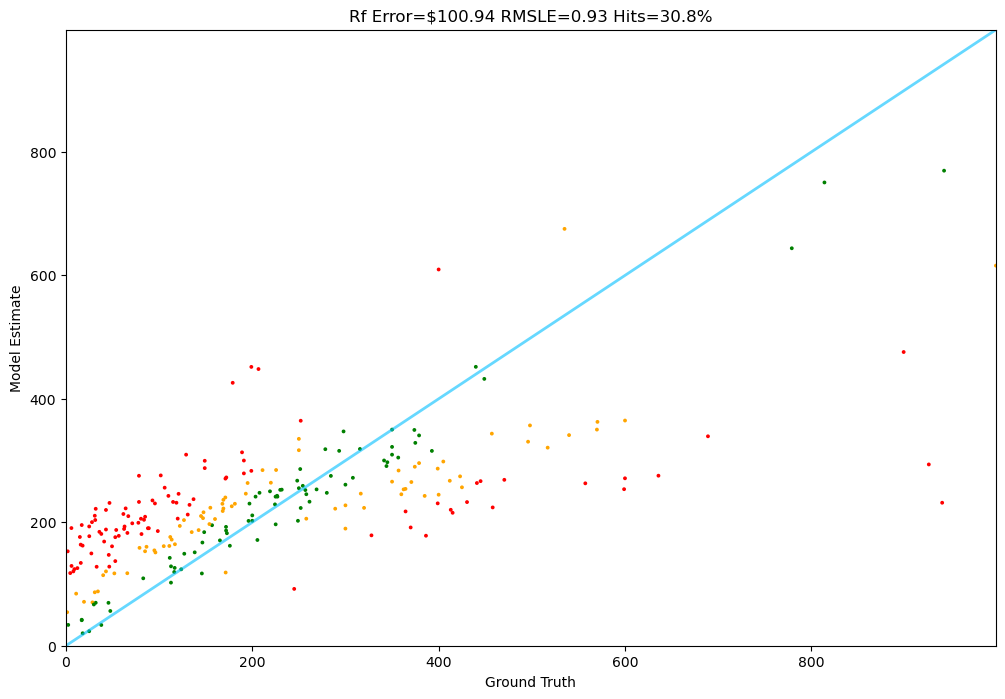

In [25]:
Tester.test(rf, test)

In [10]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [20]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
139.99
285.35880000000014


In [26]:
specialists = []
frontiers = []
random_forests = []
y = []
for item in tqdm(test[1000:1500]):
    text = get_text(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    y.append(item.price)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [27:07<00:00,  3.26s/it]


In [31]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
ys = pd.Series(y)

In [7]:
from agents.ensemble_agent import EnsembleAgent

In [8]:
ensemble = EnsembleAgent(collection)

/Users/ed/miniconda3/envs/llms/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
ensemble.price(product)

167.48065555695882

In [13]:
def ensemble_pricer(item):
    return ensemble.price(get_text(item))

1: Guess: $380.72 Truth: $374.41 Error: $6.31 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $212.41 Truth: $225.11 Error: $12.70 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.22 Truth: $61.68 Error: $11.46 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $383.93 Truth: $599.99 Error: $216.06 SLE: 0.20 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $31.47 Truth: $16.99 Error: $14.48 SLE: 0.35 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $36.44 Truth: $31.99 Error: $4.45 SLE: 0.02 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $98.08 Truth: $101.79 Error: $3.71 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $377.50 Truth: $289.00 Error: $88.50 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $810.00 Truth: $635.86 Error: $174.14 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $81.17 Truth: $65.99 Error: $15.18 SLE: 0.04 Item

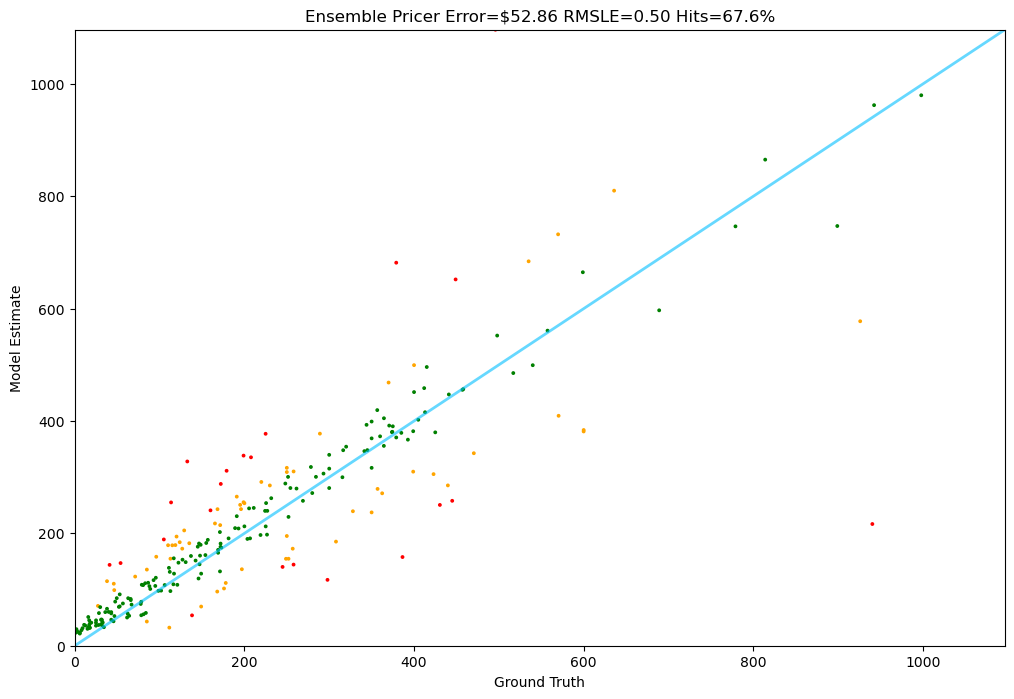

In [14]:
Tester.test(ensemble_pricer, test)

In [32]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, ys)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.28
Frontier: 0.41
RandomForest: -0.29
Min: 0.35
Max: 0.22
Intercept=25.61


In [33]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [ ]:
print(proprietary(test[1]))
print(gpt_4o_mini_rag(test[1]))

In [ ]:
truths = []
proprietaries = []
rags = []
for i in tqdm(range(1000,1250)):
    item = test[i]
    truths.append(item.price)
    proprietaries.append(proprietary(item))
    rags.append(gpt_4o_mini_rag(item))

In [ ]:
mins = [min(p,r) for p,r in zip(proprietaries, rags)]
maxes = [max(p,r) for p,r in zip(proprietaries, rags)]

X = pd.DataFrame({
    'Proprietary': proprietaries,
    'RAG': rags,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(truths)

In [ ]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = ["Proprietary", "RAG", "Min", "Max"]

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

In [ ]:
def ensemble(item):
    prop = proprietary(item)
    rag = gpt_4o_mini_rag(item)
    Xt = pd.DataFrame({
    'Proprietary': [prop],
    'RAG': [rag],
    'Min': [min(prop,rag)],
    'Max': [max(prop,rag)],
    })
    yt = lr.predict(Xt)
    return yt[0]

In [ ]:
ensemble(test[0])

In [ ]:
test[0].price

In [ ]:
Tester.test(ensemble, test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(vectors, prices)

In [ ]:
def new_rf(item):
    text = item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]
    return 

In [ ]:
Tester.test(new_rf, test)

In [ ]:
forests = []
for item in tqdm(test[1000:1250]):
    description = item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]
    forests.append(new_rf(item))

In [ ]:
truths2 = []
proprietaries2 = []
rags2 = []
forests2 = []
for i in tqdm(range(1000,2000)):
    item = test[i]
    truths2.append(item.price)
    proprietaries2.append(proprietary(item))
    rags2.append(gpt_4o_mini_rag(item))
    forests2.append(new_rf(item))

In [ ]:
mins2 = [min(p,r,f) for p,r,f in zip(proprietaries2, rags2, forests2)]
maxes2 = [max(p,r,f) for p,r,f in zip(proprietaries2, rags2, forests2)]



X2 = pd.DataFrame({
    'Proprietary': proprietaries2,
    'RAG': rags2,
    'Forest': forests2,
    'Min': mins2,
    'Max': maxes2,
})

# Convert y to a Series
y2 = pd.Series(truths2)

In [ ]:
# Train a Linear Regression
np.random.seed(42)

lr2 = LinearRegression()
lr2.fit(X2, y2)

feature_columns = X2.columns.tolist()

for feature, coef in zip(feature_columns, lr2.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

In [ ]:
def ensemble2(item):
    prop = proprietary(item)
    rag = gpt_4o_mini_rag(item)
    r_f = new_rf(item)
    Xt2 = pd.DataFrame({
    'Proprietary': [prop],
    'RAG': [rag],
    'Forest': [r_f],
    'Min': [min(prop,rag, r_f)],
    'Max': [max(prop,rag, r_f)],
    })
    yt2 = lr.predict(Xt2)
    return yt2[0]

In [ ]:
Tester.test(ensemble2, test)